 # Quora Question Pairs
 Capstone Project: Eric Canull

In [1]:
# Import libraries
import datetime
import logging
import os
import warnings
from time import time

import gensim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from fuzzywuzzy import fuzz
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from nltk import word_tokenize
from nltk.corpus import stopwords
from scipy.spatial.distance import (braycurtis, canberra, chebyshev, cityblock,
                                    cosine, euclidean, jaccard, minkowski,
                                    sqeuclidean)
from scipy.stats import kurtosis, skew
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from tqdm import tqdm_notebook

import xgboost as xgb
from graphs import histogram, pie_chart, heatmap_chart
from textcleaner import clean_text, drop_null

warnings.filterwarnings("ignore")
start_nb = time()


C:\Users\ericc\Anaconda2\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# Initialize logging.
logging.basicConfig(filename='logs/quora.log',
                    format='%(asctime)s : %(levelname)s : %(message)s',
                    level=logging.INFO)


In [3]:
# Global Variables
TRAIN_FILE = "data/train.csv"
TEST_FILE = "data/test.csv"
GOOGLE_EMBEDDING_FILE = "data/googlenews/GoogleNews-vectors-negative300.bin.gz"
GLOVE_EMBEDDING_FILE = "data/glove.6B/glove.6B.200d.txt"
GLOVE_WORD2VEC_FILE = 'data/glove.6B/word2vec/glove.6B.200d.txt.word2vec'
GLOVE_WORD2VEC_MODEL = "models/glove6B.200d.word2vec.model"
GLOVE_WORD2VEC_NORM_MODEL = "models/glove6B.200d.word2vec.norm.model"
Q1_WMD_TRAINING_DATA_FILE = 'data/npy/q1_wmd_train.npy'
Q2_WMD_TRAINING_DATA_FILE = 'data/npy/q2_wmd_train.npy'
EMBEDDING_DIM = 200

stops = set(stopwords.words("english"))


In [4]:
# Import files
pd.options.mode.chained_assignment = None
train_df = pd.read_csv(filepath_or_buffer=TRAIN_FILE)
test_df = pd.read_csv(filepath_or_buffer=TEST_FILE)


In [5]:
# Loading into a Gensim Word2Vec model class may take several minutes.
if not os.path.exists(GLOVE_EMBEDDING_FILE):
    raise FileNotFoundError(
        "Warning! You need to download the Glove embeddings")

if not os.path.exists(GLOVE_WORD2VEC_FILE):
    glove2word2vec(GLOVE_EMBEDDING_FILE, GLOVE_WORD2VEC_FILE)
    word2vec = KeyedVectors.load_word2vec_format(
        GLOVE_EMBEDDING_FILE, binary=False)
else:
    word2vec = gensim.models.KeyedVectors.load(GLOVE_WORD2VEC_MODEL)


 ## L<sup>2</sup> unit-normalized WMD
 ### Necessary for computing cosine similiarity

In [6]:
# Loading into a Gensim Word2Vec model class may take several minutes.
if not os.path.exists(GLOVE_WORD2VEC_NORM_MODEL):
    norm_word2vec = word2vec
    norm_word2vec.init_sims(replace=True)
else:
    norm_word2vec = gensim.models.KeyedVectors.load(GLOVE_WORD2VEC_NORM_MODEL)


In [7]:
# Null counts in training set
train_df.isnull().sum()


id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [8]:
# Null counts in test set
test_df.isnull().sum()


test_id      0
question1    4
question2    6
dtype: int64

In [9]:
# Drop rows with null values
train_df = drop_null(train_df)
test_df = drop_null(test_df)



In [10]:
# Prints 10 questions at positions (0, 10, 20, etc...)
# print_null_counts(train_df, test_df)
def print_questions(df):
    a = 0
    for i in range(a, a+10):
        print(train_df.question1[i])
        print(train_df.question2[i])
        print()



In [11]:
# Training dataset summary statistics
train_df.describe()


,id,qid1,qid2,is_duplicate
count,404287.000000,404287.000000,404287.000000,404287.000000
mean,202144.340337,217243.151093,220955.212082,0.369201
std,116708.673691,157751.614317,159903.168488,0.482589
min,0.000000,1.000000,2.000000,0.000000
25%,101071.500000,74436.500000,74726.500000,0.000000
50%,202145.000000,192181.000000,197053.000000,0.000000
75%,303216.500000,346573.000000,354692.000000,1.000000
max,404289.000000,537932.000000,537933.000000,1.000000


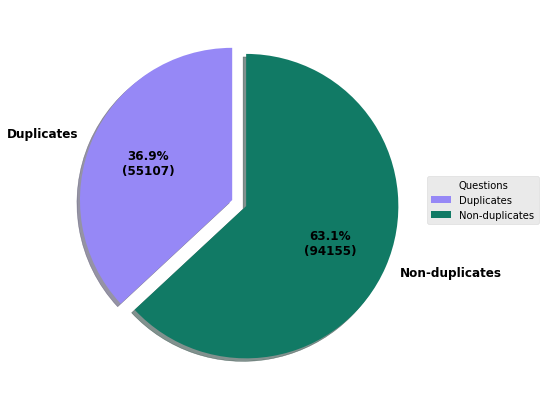

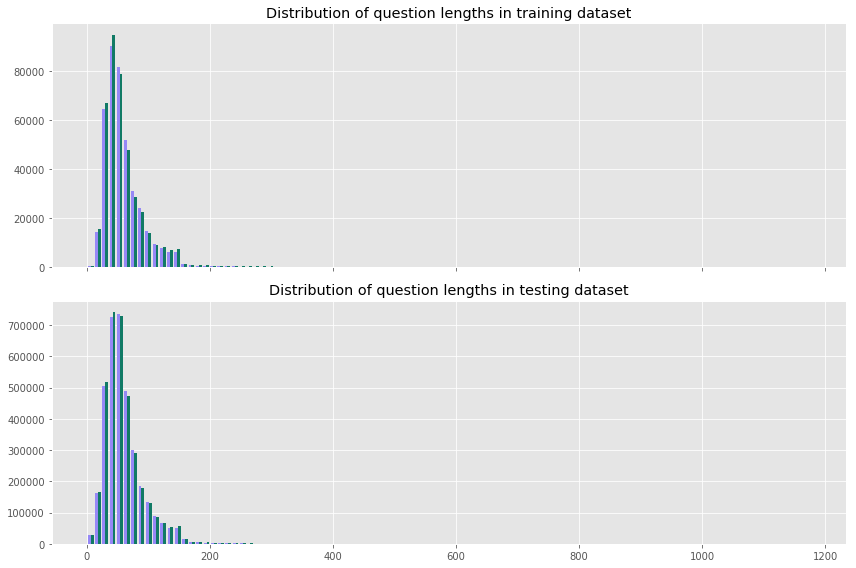

In [16]:
# Charts and graphs
plt.style.use('ggplot')
pie_chart(train_df)
histogram(train_df, test_df)
